In [1]:
import os, sys
os.environ["MKL_NUM_THREADS"]='6' 
os.environ["NUMEXPR_NUM_THREADS"]='6'
os.environ["OMP_NUM_THREADS"]='6'

import matplotlib.pyplot as plt
import autograd.numpy as np
import torch
from copy import deepcopy
from tqdm import trange, tqdm_notebook
from Datasets import LatentDynamics, Observations, SSM
from Inferences import SMC
from DDC import Features, DDC, DDCSSM, Regressors
from datetime import datetime
from scipy.stats import norm
from collections import OrderedDict
from settings import CTX

if sys.version_info[0] > 2:
    
    from importlib import reload

%matplotlib inline

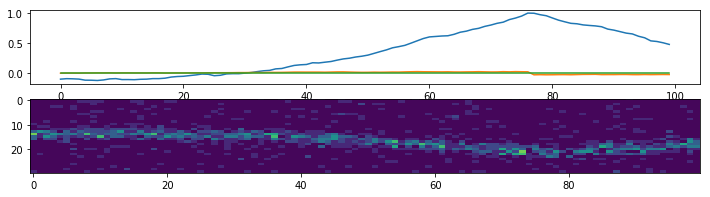

In [2]:
D = 3
Dx = 30
init_noise_std = 0.3

seed=1

#### Infer
nl = lambda x: torch.tanh(x)
dnl= lambda x: 1-torch.tanh(x)**2

np.random.seed(seed)
torch.manual_seed(seed)#
#### True

true_Z = LatentDynamics.BouncingLatent(1.0,  [0.01,2e-3,1e-15])
true_X = Observations.PoissonImageObservation(Dx, 2.0, bar_width=0.05, max_rate=3)

true_model = SSM.StateSpaceModel(true_Z, true_X, init_noise_std, 
            init_fun= lambda N: torch.randn(N,D,**CTX)*torch.tensor([0.2,0,0], **CTX))

T =100
nchain = 10
data = true_model.sample(T,10)

fig,axes = plt.subplots(2,1, figsize=(12,3))
ax = axes[0]
ax.plot(data["zt"][:,0,:].cpu().numpy())
ax = axes[1]
im = ax.imshow(data["xt"].cpu().numpy()[:,0,:].T, aspect="auto", vmin=-0.2, vmax=10.2)


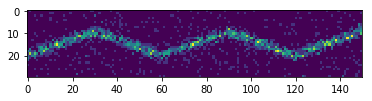

In [3]:
from scipy import signal
T_train=100
T_test = 50
T = T_train+T_test

data_v =0.05

amplitude = 1.5
time=np.linspace(0,1,T)
freq=T*data_v/(2*amplitude)
tri=np.abs(signal.sawtooth(2 * np.pi * freq * time))*amplitude-amplitude/2

nwake = 10
z0 = true_model.sample_initial(nwake)
d = true_model.step(z0,0)
test_data = true_model.sample(T, nwake)

gap = 6
test_loc = torch.tensor(tri, **CTX)
test_data["zt"][:,:,0] = test_loc[:,None]
test_data["xt"] = true_model.observation.sample(test_data["zt"])
plt.imshow(test_data["xt"][:,0,:].cpu().numpy().T)

In [4]:
M = 100
Mx= 100
adaptive=False
init_std_z = 0.5
init_std_x = 0.3

z_nl = lambda x: torch.tanh(x)
samples = true_model.sample(T,100)
zt_samples = samples["zt"].view(-1, D)
zt_mean, zt_std = zt_samples.mean(0).cpu().numpy(), zt_samples.std(0).cpu().numpy()

map_z = Features.ContinuousFeature(M,  D,  init_std_z, [-2,2], 
                                   adaptive=adaptive, nl = z_nl)

map_x = Features.ContinuousFeature(Mx, Dx, init_std_x, [-1, 5], adaptive=adaptive)

fs ={ 
      "xt": map_x,
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z),
}

fs_pre ={ "xt":   deepcopy(map_x),
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z),
}

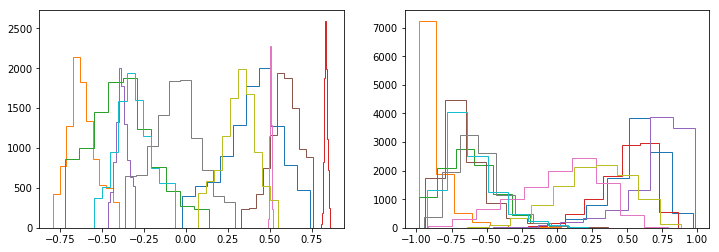

In [5]:
data = true_model.sample(100,100)

fz = fs["zt"](data["zt"]).cpu().detach()
fx = fs["xt"](data["xt"]).cpu().detach()

fig, axes= plt.subplots(1,2,figsize=(12,4))
for i in range(min(M,10)):
    axes[0].hist(fz.reshape(-1, M)[:,i], alpha=1.0,histtype='step');
for i in range(min(Mx,10)):
    axes[1].hist(fx.reshape(-1, Mx)[:,i], alpha=1.0,histtype='step');

In [6]:
# step_reg = Regressors.LinearRegressorStep(fs,lr=0.01,momentum=0.0, lam=1e-3, niter=1)

reg = Regressors.LinearRegressor(fs,lam=1e-3, tensor_op="c", lr=0.00)
torch.manual_seed(3)
# opt = Optimizers.SGDOptimizer(lr=0.001, momentum=0.9, decay=0.0)
ddc=DDCSSM.DecayDistributionRegression([1]*5,(true_model), (reg), 
                                  opt=None, 
                                  s_type="sample", 
                                  g_type="exp", 
                                  smoothing=False, 
                                  nsleep=10000, 
                                  nwake=10,
                                  plastic=[True, True], 
                                  factorise=False,
                                  stationary=False,
                                  nretain = T_test,
                                  look_back=10,
                                      )

In [7]:
d = test_data["xt"]
ddc.initialise(d[0])

for t in tqdm_notebook(range(1,T+1)):
    
    ddc.reg.R2s={}
    if t <=T_train:
        ddc.sleep_train_test()
    else:
        ddc.sleep_test()
    if t != T:
        ddc.propagate(d[t])

ddc.finalise()

In [8]:
ddc.wake_history["Ezt-0_x1:t"]=ddc.wake_history["Ezt_x1:t"]

In [9]:
nlag=10
errors=[]
test_data_z = test_data["zt"].cpu().numpy()

In [10]:
test_x = test_data["xt"].cpu().numpy()
test_z = test_data["zt"].cpu().numpy()

T = T
T_train=T_train
ddc_keys = []
ddc_means =[]
for i in range(0, ddc.look_back):
    ddc_keys += "Ezt-%d_x1:t"%i,

    ddc_means += np.concatenate([ddc.wake_history.data["Ezt-%d_x1:t"%i][i:],
                                np.full((i,nwake,D), np.nan)], 0),

In [11]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/nfs/nhome/live/kevinli/anaconda/envs/ddc_ssm_3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


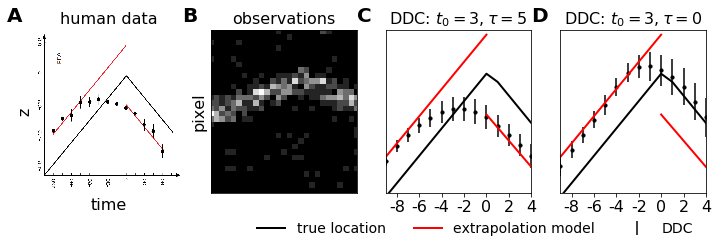

In [12]:
batch_idx=0
letter_ascii=0
t_0 = 3
def add_letter(ax,letter_ascii):
    ax.text(-0.2,1.05,chr(letter_ascii), transform=ax.transAxes, 
            fontsize=20, fontweight="heavy")
    letter_ascii+=1
decode_lags=[5,0]
ddc_color=[0.0,0.0,0.0]
true_color=[0,0,0]
letter_ascii = 65

true_x = test_x[T_train:,batch_idx]
true_z = test_z[T_train:,batch_idx,0]
fig, axes = plt.subplots(1,len(decode_lags)+2,figsize=(12,3), sharex=False, sharey=False)

from scipy.misc import imread
ax = axes[0]
#deprecated
im = imread("figs/flash_human.png")
ax.imshow(im.transpose((1,0,2))[::-1,::-1],aspect="auto")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim()
add_letter(ax,letter_ascii)

ax.set_xlabel("time", labelpad=5)

ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("human data")
letter_ascii += 1
ax.set_ylabel("z")


Ts = np.arange(T-T_train)

ax =axes[1]
ax.imshow(true_x.T, aspect="auto", origin="lower", cmap="gray")
ax.set_xlim(-0.5,Dx-0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("observations")
ax.set_xlim(3,29)
ax.set_ylabel("pixel")
add_letter(ax,letter_ascii)
letter_ascii+=1

t_peak = np.argmax(true_z)

for li, lag in enumerate(decode_lags):
    ax = axes[2+li]

    true_z = test_z[T_train:,batch_idx,0]
    
    ax.plot(true_z, color=true_color, lw=2, label="true location")
    
    ax.plot([Ts[0]-t_0, t_peak-t_0+t_0], [true_z[0], true_z[0]+0.05*(t_peak+t_0)], 
            color="r", lw=2, ls="-",label="extrapolation model")
    ax.plot([t_peak-t_0+t_0, Ts[-1]-t_0], 
            [true_z[t_peak]-0.05*(t_0), true_z[t_peak]-0.05*(Ts[-2]-t_peak)], 
            color="r", lw=2, ls="-")

    ddc_z  = ddc_means[lag][:,:,0]
    ddc_z_mean = ddc_z.mean(-1)
    ddc_z_std = ddc_z.std(-1)
    ax.scatter(Ts[::]-t_0, ddc_z_mean[::], 10, "k", marker='o')
    ax.errorbar(Ts[::]-t_0, ddc_z_mean[::], yerr=ddc_z_std[::], color=ddc_color,
                label="DDC", fmt='none')
    
#     ax.errorbar(Ts[::2], ddc_z_mean[::2], yerr=ddc_z_std[::2], color="gray",
#                 label="real-time", fmt='')
    
    ax.set_title(r"DDC: $t_0=%d,\tau=%d$"%(t_0, max(0,lag)))
    ax.set_ylim(0.3,0.9)
    ax.set_yticks([])

    
    ax.set_xticks(np.arange(t_peak-20,t_peak+20,2))
    ax.set_xticklabels(np.arange(-20,20,2))
    ax.set_xlim(10,23)

    add_letter(ax,letter_ascii)
    letter_ascii += 1




Ts = np.arange(T-T_train)

'''
ax = axes[-1]


ax.errorbar(Ts[::2], pf_pm[...,0].mean(-1)[::2], yerr=pf_pm[...,0].std(-1)[::2], 
            color="gray",fmt='')

ax.plot(true_z, color=true_color, lw=2, label="truth")

ax.plot([Ts[0]-t_0, t_peak-t_0+t_0], [true_z[0], true_z[0]+0.05*(t_peak+t_0)], 
        color="r", lw=2, ls="-",label="extrapolation model")
ax.plot([t_peak-t_0+t_0, Ts[-1]-t_0], 
        [true_z[t_peak]-0.05*(t_0), true_z[t_peak]-0.05*(Ts[-2]-t_peak)], 
        color="r", lw=2, ls="-")

ax.set_ylim(-1,1)
ax.set_yticks([])
ax.set_title("ADF")
    
ax.set_xlim(3,28)
ax.set_ylim(0,1.1)
ax.set_yticks([0,1])
add_letter(ax,letter_ascii)
    
axes[2].set_ylim(0,1.1)
axes[2].set_yticks([0,1])
axes[-1].set_ylabel(r"$\langle z_{t-t_0}\rangle_q$", labelpad=-1)
axes[2].set_ylabel(r"$\langle z_{t-t_0-\tau}\rangle_q$", labelpad=-10)
fig.tight_layout()
'''
axes[-2].legend(loc="upper right", bbox_to_anchor=(2.2,-0.1), frameon=False, ncol=5)

# fig.savefig("figs/flash.pdf", pad_inches=0, bbox_inches="tight")